In [1]:
import os
import sys

# Get the absolute path of the directory where the notebook file is located
notebook_dir = os.path.dirname(os.path.realpath("__file__"))

# Append the 'src' and 'utils' directories to the Python path
# Navigate up one level to the parent directory and then into 'src' and 'utils'
parent_dir = os.path.dirname(notebook_dir)
sys.path.append(os.path.join(parent_dir, 'SRC'))
sys.path.append(os.path.join(parent_dir, 'UTILS'))

# Now you can import your modules
from preprocess.preprocess_hnmr import parse_sequence, pad_sequence, preprocess_sequence, convert_to_ints, compound_tensor
from preprocess.preprocess_smiles import tokenized_smiles_to_tensor
from models.GAN_model import Discriminator, Generator
from models.LSTM_model import Encoder, Decoder, Seq2Seq


# Class imports

from preprocess.data_handler import SMILESDataset

sequence_data = open("C:\\Users\\patri\\OneDrive\\Desktop\\NMR_GAN\\data\\src-train.txt", 'r').readlines()
target_data = open("C:\\Users\\patri\\OneDrive\\Desktop\\NMR_GAN\\data\\tgt-train.txt", 'r').readlines()

In [2]:
from rdkit import Chem
from rdkit.Chem import Draw

# SMILES string
smiles = target_data[13]

smiles_no_spaces = smiles.replace(' ', '')

mol = Chem.MolFromSmiles(smiles_no_spaces)

# Draw the molecule
img = Draw.MolToImage(mol)

# Display the molecule
img.show()


Tokenize the training data (move tgt-train.txt to the UTILS/preprocess/tests/data folder)

In [3]:
# call tokenize_data.py using subprocess
import subprocess
subprocess.call(['python', 'C:\\Users\\patri\\OneDrive\\Desktop\\NMR_GAN\\UTILS\\tokenize_data.py', '-i', 'C:\\Users\\patri\\OneDrive\\Desktop\\NMR_GAN\\data\\src-train.txt', '-o', 'C:\\Users\\patri\\OneDrive\\Desktop\\NMR_GAN\\data\\src-train.txt.tok', '-t', 'src'])



2

Preprocess the HNMR training data


In [4]:
# Preprocess the HNMR training data

subprocess.call(['python', 'C:\\Users\\patri\\OneDrive\\Desktop\\NMR_GAN\\UTILS\\preprocess_hnmr.py', '-i', 'C:\\Users\\patri\\OneDrive\\Desktop\\NMR_GAN\\data\\src-train.txt', '-o', 'C:\\Users\\patri\\OneDrive\\Desktop\\NMR_GAN\\data\\training_tensor.pt', '-t', 'src'])


2

You should now see tensors.pt in your UTILS/preprocess/tests/data directory. Now we have the tensorized src training data (HNMR values) and the tokenized smiles data. 

In [5]:
tokenized_smiles_to_tensor(
    input_file = "C:\\Users\\patri\\OneDrive\\Desktop\\NMR_GAN\\UTILS\\preprocess\\tests\\data\\tokenized_tgt-train.txt", 
    output_file = "C:\\Users\\patri\\OneDrive\\Desktop\\NMR_GAN\\UTILS\\preprocess\\tests\\data\\smiles_tensor.pt", 
    sequence_length = 250
    )

sequences_tensor.shape: torch.Size([1277, 250])


Instantiate the LSTM model and load in the tensor data

In [7]:
# Loading tensors
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

loaded_input_tensor = torch.load('C:\\Users\\patri\\OneDrive\\Desktop\\NMR_GAN\\UTILS\\preprocess\\tests\\data\\training_tensors.pt')
loaded_output_tensor = torch.load('C:\\Users\\patri\\OneDrive\\Desktop\\NMR_GAN\\UTILS\\preprocess\\tests\\data\\training_smiles_tensor.pt')

# Assuming loaded_input_tensor and loaded_output_tensor are already loaded

# Create an instance of the Dataset
smiles_dataset = SMILESDataset(loaded_input_tensor, loaded_output_tensor)

# Create the DataLoader
batch_size = 32  # Example batch size, can be tuned
smiles_dataloader = DataLoader(smiles_dataset, batch_size=batch_size, shuffle=True)



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Example sizes
INPUT_SIZE = 4
HIDDEN_SIZE = 50
OUTPUT_SIZE = 33
NUM_LAYERS = 1

encoder = Encoder(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS)
decoder = Decoder(OUTPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS)

model = Seq2Seq(encoder, decoder, device).to(device)


# Assuming loaded_input_tensor is correctly shaped [1277, 20, 4]
target_length = 250  # or whatever your desired output sequence length is

output_tensor = model(loaded_input_tensor, target_length)
print(output_tensor.shape)  # Should now be compatible



torch.Size([1277, 250, 33])


Load the data

In [8]:
# Assuming you have your data in 'data' and targets in 'targets'
dataset = SMILESDataset(loaded_input_tensor, loaded_output_tensor)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)


Now lets train the model

In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss(ignore_index=1)  # or another appropriate loss function
optimizer = optim.Adam(model.parameters(), lr=0.000001)  # learning rate can be adjusted


c:\Users\patri\OneDrive\Desktop\NMR_GAN\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
device

device(type='cpu')

t 0
loss tensor(3.3870, grad_fn=<AddBackward0>)
t 1
loss tensor(6.8835, grad_fn=<AddBackward0>)
t 2
loss tensor(10.3800, grad_fn=<AddBackward0>)
t 3
loss tensor(13.8765, grad_fn=<AddBackward0>)
t 4
loss tensor(17.3730, grad_fn=<AddBackward0>)
t 5
loss tensor(20.8695, grad_fn=<AddBackward0>)
t 6
loss tensor(24.3660, grad_fn=<AddBackward0>)
t 7
loss tensor(27.8625, grad_fn=<AddBackward0>)
t 8
loss tensor(31.3591, grad_fn=<AddBackward0>)
t 9
loss tensor(34.8556, grad_fn=<AddBackward0>)
t 10
loss tensor(38.3521, grad_fn=<AddBackward0>)
t 11
loss tensor(41.8486, grad_fn=<AddBackward0>)
t 12
loss tensor(45.3451, grad_fn=<AddBackward0>)
t 13
loss tensor(48.8416, grad_fn=<AddBackward0>)
t 14
loss tensor(52.3381, grad_fn=<AddBackward0>)
t 15
loss tensor(55.8346, grad_fn=<AddBackward0>)
t 16
loss tensor(59.3311, grad_fn=<AddBackward0>)
t 17
loss tensor(62.8276, grad_fn=<AddBackward0>)
t 18
loss tensor(66.3241, grad_fn=<AddBackward0>)
t 19
loss tensor(69.8206, grad_fn=<AddBackward0>)
t 20
loss te

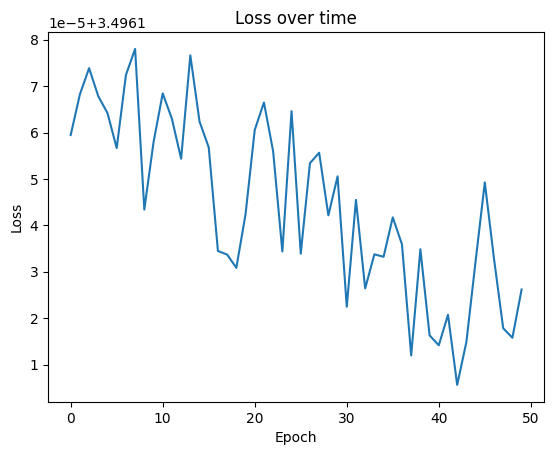

In [33]:
import matplotlib.pyplot as plt

num_epochs = 50  # Set the number of epochs
loss_values = []  # Store loss values

for epoch in range(num_epochs):
    running_loss = 0.0

    for inputs, targets in data_loader:  # Assuming data_loader is your batched data
        optimizer.zero_grad()   # Zero the parameter gradients

        # Forward pass: Specify both inputs and target_length
        target_length = 250  # Replace with your actual target length
        outputs = model(inputs, target_length)

        loss = 0
        for t in range(target_length):  # Iterating over each time step
            print('t', t)
            loss += criterion(outputs[:, t, :], targets[:, t].long())
            print('loss', loss)
        loss /= target_length  # Average over the sequence length

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    average_loss = running_loss / len(data_loader)  # Assuming data_loader is the name of your data loader
    loss_values.append(average_loss)  # Store loss value
    print(f"Epoch {epoch+1}, Average Loss: {average_loss}")

# Assuming 'model' is your model instance
model_state_file = 'C:\\Users\\patri\\OneDrive\\Desktop\\NMR_GAN\\UTILS\\preprocess\\tests\\data\\seq2seq_model.pth'
torch.save(model.state_dict(), model_state_file)

# Plot loss over time
plt.plot(loss_values)
plt.title('Loss over time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


Looks like the model training went well. Now lets load in our training data

In [12]:
# call tokenize_data.py using subprocess
import subprocess
subprocess.call(['python', 'C:\\Users\\patri\\OneDrive\\Desktop\\NMR_GAN\\UTILS\\tokenize_data.py', '-i', 'C:\\Users\\patri\\OneDrive\\Desktop\\NMR_GAN\\data\\src-test.txt', '-o', 'C:\\Users\\patri\\OneDrive\\Desktop\\NMR_GAN\\data\\src-test.txt.tok', '-t', 'src'])


2

In [13]:
# Preprocess the HNMR training data

subprocess.call(['python', 'C:\\Users\\patri\\OneDrive\\Desktop\\NMR_GAN\\UTILS\\preprocess_hnmr.py', '-i', 'C:\\Users\\patri\\OneDrive\\Desktop\\NMR_GAN\\data\\src-test.txt', '-o', 'C:\\Users\\patri\\OneDrive\\Desktop\\NMR_GAN\\data\\testing_tensor.pt', '-t', 'src'])

2

In [14]:
tokenized_smiles_to_tensor(
    input_file = "C:\\Users\\patri\\OneDrive\\Desktop\\NMR_GAN\\UTILS\\preprocess\\tests\\data\\tokenized_tgt-test.txt", 
    output_file = "C:\\Users\\patri\\OneDrive\\Desktop\\NMR_GAN\\UTILS\\preprocess\\tests\\data\\testing_smiles_tensor.pt", 
    sequence_length = 250
    )

sequences_tensor.shape: torch.Size([143, 250])


In [34]:
# Loading tensors
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
testing_input_tensor = torch.load('C:\\Users\\patri\\OneDrive\\Desktop\\NMR_GAN\\UTILS\\preprocess\\tests\\data\\testing_tensors.pt')
testing_output_tensor = torch.load('C:\\Users\\patri\\OneDrive\\Desktop\\NMR_GAN\\UTILS\\preprocess\\tests\\data\\testing_smiles_tensor.pt')
# Assuming you have your data in 'data' and targets in 'targets'
dataset = SMILESDataset(testing_input_tensor, testing_output_tensor)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

Load the model weights

In [35]:
# Recreate the model (make sure it has the same architecture)
model = Seq2Seq(encoder, decoder, device)  # Replace with your model class and args

# Load the saved state dict
model.load_state_dict(torch.load(model_state_file))

# Remember to set the model to evaluation mode if you are making predictions
model.eval()


Seq2Seq(
  (encoder): Encoder(
    (lstm): LSTM(4, 50, batch_first=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(33, 50)
    (lstm): LSTM(50, 50, batch_first=True)
    (fc): Linear(in_features=50, out_features=33, bias=True)
  )
)

In [36]:
with torch.no_grad():  # Turn off gradients for prediction
    prediction = model(testing_input_tensor, target_length)  # 'target_length' is the expected length of output sequence


In [37]:
prediction.shape

torch.Size([143, 250, 33])

In [42]:
prediction[50,1,:]


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])

Now lets translate back to smiles

In [ ]:
def load_reverse_vocab(vocab_file):
    reverse_vocab = {}
    with open(vocab_file, 'r') as file:
        for line in file:
            char, idx = line.split()
            reverse_vocab[int(idx)] = char
    return reverse_vocab

# Load reverse vocabulary
reverse_vocab = load_reverse_vocab('C:\\Users\\patri\\OneDrive\\Desktop\\NMR_GAN\\UTILS\\preprocess\\tests\\data\\vocab.txt')

def indices_to_smiles(indices, reverse_vocab):
    return ''.join(reverse_vocab[idx] for idx in indices if idx in reverse_vocab)

# Example usage
predicted_indices = [15, 20, 15]  # Example output from your model
predicted_smiles = indices_to_smiles(predicted_indices, reverse_vocab)
print(predicted_smiles)  # Outputs the corresponding SMILES string

